In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda, AvgPool1D
import librosa
import librosa.display
from scipy.io import wavfile
import pyhocon
import h5py
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [4]:
tf.range(0,60,2.5)

<tf.Tensor: shape=(24,), dtype=float32, numpy=
array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
       27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5,
       55. , 57.5], dtype=float32)>

In [6]:
task = 'raga'
tradition = 'hindustani'

config = pyhocon.ConfigFactory.parse_file("experiments.conf")[task]

processes = ['train', 'validate', 'test']
data_paths = []
data = []
for p in processes:
    data_path = config[tradition+'_'+p]
    data_paths.append(data_path)
    temp = pd.read_csv(data_path, sep='\t')
    data.append(temp)
data = pd.concat(data, axis=0)
lm_file = h5py.File(config[tradition+'_cqt_cache'], "r")

In [7]:
data.head()

,path,mbid,rag_id,old_path,tonic,tonic_fine,len,rag_name,labels
0,data\ragadataset\audio\00f54612-09f6-4528-91f1...,00f54612-09f6-4528-91f1-95e5ef191c1b,fa28470c-d413-44c7-94da-181f530cbfdd,data\ragadataset/hindustani/audio/fa28470c-d41...,212.505992,212.138066,1666.429375,puriyā dhanaśrī,29
1,data\ragadataset\audio\d44c1914-b3ee-4948-af86...,d44c1914-b3ee-4948-af86-d07fde13c1b4,a99e07d5-20a0-467b-8dcd-aa5a095177fd,data\ragadataset/hindustani/audio/a99e07d5-20a...,143.478728,143.644577,1939.826937,lalit,19
2,data\ragadataset\audio\a5b15aae-c911-4df5-944d...,a5b15aae-c911-4df5-944d-1d0d95b8b5b0,0b3bbf97-0ec3-41da-add4-722d87329ec3,data\ragadataset/hindustani/audio/0b3bbf97-0ec...,222.556277,221.914437,115.095500,madhukauns,1
3,data\ragadataset\audio\932be692-9ff8-4fe1-8546...,932be692-9ff8-4fe1-8546-b92b2d3db696,54c4214c-05b9-4acc-8f77-6d5786e43a2e,data\ragadataset/hindustani/audio/54c4214c-05b...,233.000000,232.000000,534.073437,mārūbihāg,11
4,data\ragadataset\audio\e59642ca-72bc-466b-bf4b...,e59642ca-72bc-466b-bf4b-d82bfbc7b4af,48b37bed-e847-4882-8a01-5c721e07f07d,data\ragadataset/hindustani/audio/48b37bed-e84...,139.394167,139.394167,1467.040000,yaman kalyāṇ,10


In [8]:
def freq_to_cents(freq, std=25):
    frequency_reference = 10
    c_true = 1200 * math.log(freq / frequency_reference, 2)

    cents_mapping = np.linspace(0, 7180, 360) + 1997.3794084376191
    target = np.exp(-(cents_mapping - c_true) ** 2 / (2 * std ** 2))
    return target


In [9]:
def get_cqt(audio,sr=16000):
    C = np.abs(librosa.cqt(audio, sr=sr, bins_per_octave=60, n_bins=60*7, pad_mode='wrap',fmin=librosa.note_to_hz('C1')))
#     librosa.display.specshow(C, sr=sr,x_axis='time', y_axis='cqt', cmap='coolwarm')

    fig, ax = plt.subplots()
    c_cqt = librosa.amplitude_to_db(C, ref=np.max)
    c_cqt = np.reshape(c_cqt, [7,60,-1])
    c_cqt = np.mean(c_cqt, axis=0)
#     img = librosa.display.specshow(c_cqt,
#                                sr=sr, x_axis='time', y_axis='cqt_note', ax=ax,bins_per_octave=60)
#     ax.set_title('Constant-Q power spectrum')
#     fig.colorbar(img, ax=ax, format="%+2.0f dB")
    return c_cqt


In [10]:
def get_cqt_array(audio_path, tonic):
    sr, audio = wavfile.read(audio_path)
    # slice_ind = 16000*300
    # slice_ind = 10
    # audio = audio[slice_ind * 16000:(slice_ind + 1) * 16000*300]
    cqt = get_cqt(audio)
    cqt = np.roll(cqt, -np.argmax(freq_to_cents(tonic)), axis=0)
    cqt = tf.transpose(cqt)


In [11]:
def get_histograms(red_y, cqt):
    red_y_mean = tf.math.reduce_mean(red_y, 0)
    red_y_std = tf.math.reduce_std(red_y, 0)
    cqt_mean = tf.math.reduce_mean(cqt, 0)
    cqt_std = tf.math.reduce_std(cqt, 0)
    cqt_mean = tf.roll(cqt_mean, 3, axis=-1)
    cqt_std = tf.roll(cqt_std, 3, axis=-1)

    return [red_y_mean, red_y_std, cqt_mean, cqt_std]

In [104]:
def get_unique_seq_1(arg_y, red_y):
    # red_y = tf.random.uniform(shape=(100,), maxval=60, dtype=tf.int32)
    # red_y  = tf.one_hot(red_y,60)
#     red_y_p = tf.reduce_max(red_y, axis=1)
    red_y_p = tf.ones_like(arg_y)
    arg_y = tf.concat([arg_y, [60]], axis=-1)  # None+1
    arg_y_shifted = tf.roll(arg_y, 1, axis=-1)  # 1,None
    arg_y = arg_y[:-1]
    arg_y_shifted = arg_y_shifted[:-1]

    mask = tf.cast(tf.not_equal(arg_y, arg_y_shifted), tf.float32)  # 1,None+1

    mask_cumsum = tf.math.cumsum(mask)-1
    mask_cumsum = tf.math.segment_sum(red_y_p, tf.cast(mask_cumsum, tf.int32))
    mask = tf.where(mask)[:, 0]
    # mask_pad = tf.concat([[0], tf.cast(mask, tf.int32)], axis=0)
    # mask_roll = tf.roll(mask_pad, -1, axis=-1)
    # mask_roll = tf.math.abs(mask_roll - mask_pad)[:-1]
    #     print(mask_roll)
    uni_seq_notes = tf.gather(arg_y, mask)
    uni_seq_notes = tf.cast(uni_seq_notes, tf.int32)
    return uni_seq_notes, mask_cumsum

In [97]:
def get_unique_seq_2(ndms):
    temp = tf.equal(ndms, tf.roll(ndms, -2, axis=-1))
    temp1 = tf.cast(tf.logical_not(tf.roll(temp, 1, axis=-1)), tf.int32)
    temp2 = tf.cast(temp, tf.int32)

    uni_seq_notes = tf.multiply(ndms, temp1) + tf.roll(tf.multiply(ndms, temp2), 1, axis=-1)
    return uni_seq_notes

In [13]:
def cluster_top_notes(red_y, top_notes):
#     arg_y = tf.argmax(red_y, axis=1)
#     red_y = tf.one_hot(arg_y, 60)
#     red_y_mul = tf.multiply(red_y, top_notes)
#     red_y_mul_sum = tf.reduce_sum(red_y_mul, axis=1)
#     top_notes_where = tf.where(red_y_mul_sum)[:, 0]
#     top_notes_where = tf.gather(arg_y, top_notes_where)
#     top_notes_where = tf.cast(top_notes_where, tf.int32)
#     print(top_notes_where)
#     return top_notes_where
#     c_note = freq_to_cents(31.7 * 2)
#     c_note = np.reshape(c_note, [6, 60])
#     c_note = np.sum(c_note, axis=0)

    top_notes_where = tf.where(top_notes)[:, 0]
    top_notes_where = tf.tile(tf.expand_dims(top_notes_where, 0), [tf.shape(red_y)[0], 1])
    red_y_arg = tf.argmax(red_y, axis=1)
    red_y_arg = tf.expand_dims(red_y_arg, 1)
    diff = tf.math.abs(red_y_arg - top_notes_where)
    diff = tf.argmin(diff, 1)
    diff_ohe = tf.one_hot(diff, tf.shape(top_notes_where)[1])
    top_notes_where = tf.multiply(tf.cast(top_notes_where, tf.float32), diff_ohe)
    top_notes_where = tf.reduce_max(top_notes_where, axis=1)
    top_notes_where = tf.cast(top_notes_where, tf.int32)
    return top_notes_where

In [281]:
def dist_mat():
    mat = np.zeros((60,60))
    for x1 in range(60):
        for x2 in range(60):
            x3 = abs(x1-x2)
            x3 = np.minimum(x3, 60-x3)
            mat[x1,x2] = x3
    return normalize(mat)

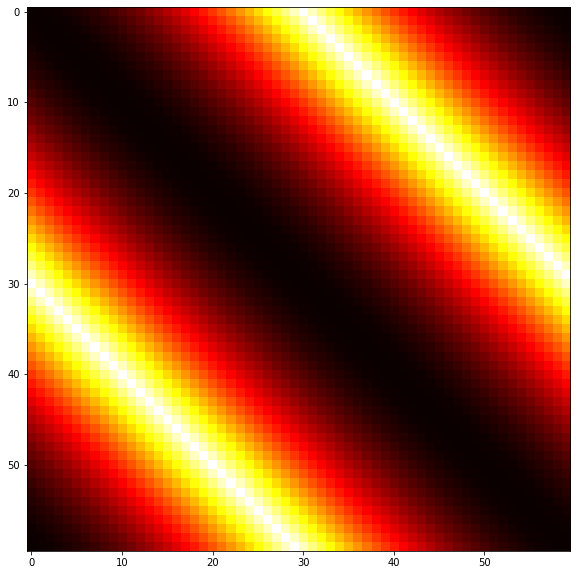

In [279]:

plt.figure(figsize=(10,10))
plt.imshow(dist_mat(), cmap='hot', interpolation='nearest')

plt.show()

In [288]:
def get_ndms_mat(ndms, ndms_val, shift=-1):
    c_note = freq_to_cents(31.7 * 2,25)
    c_note = np.reshape(c_note, [6,60])
    c_note = np.sum(c_note,axis=0)
    ndms_ohe = tf.keras.layers.Lambda(lambda x: tf.map_fn(lambda a: tf.roll(tf.constant(c_note), a, axis=-1), x, tf.float64))(ndms)
#     ndms_ohe = tf.one_hot(tf.cast(ndms, tf.int32), 60)
    ndms_ohe = tf.cast(ndms_ohe, tf.float64)
    ndms_roll_ohe = tf.roll(ndms_ohe, shift, axis=0)
    
#     x3 = tf.math.abs(tf.argmax(ndms_ohe, axis=1) - tf.argmax(ndms_roll_ohe, axis=1))
    
#     x3 = tf.cast(x3, tf.float64)
#     x3 = tf.math.log(x3+1)
#     ndms_val = tf.math.log(tf.cast(ndms_val, tf.float64))
#     ndms_val = x3
#     print(ndms_val)
    ndms_val = tf.cast(tf.expand_dims(ndms_val,1), tf.float64)
#     ndms_ohe = tf.multiply(ndms_ohe, tf.math.log(ndms_val+1))
    ndms_ohe = tf.multiply(ndms_ohe, ndms_val)
    ndms_roll_ohe = tf.multiply(ndms_roll_ohe, tf.roll(ndms_val, shift, axis=0))
    
    # ndms_roll_ohe = tf.keras.layers.Lambda(lambda x: tf.map_fn(lambda a: tf.roll(tf.constant(c_note), a, axis=-1), x, tf.float64))(ndms_roll)
    # ndms_roll_ohe = tf.roll(ndms_ohe, -1, axis=0)
    # ndms_ohe = tf.one_hot(ndms, 60)
    # ndms_roll = tf.roll(ndms, -1, axis=-1)
    # ndms_roll_ohe = tf.one_hot(ndms_roll, 60)
    matmul = tf.matmul(ndms_ohe, ndms_roll_ohe, transpose_a=True)
#     matmul = normalize(normalize(matmul)*normalize(dist_mat()))
#     matmul = normalize(matmul)
    return matmul

In [15]:
def standardize(z):
    return (z - tf.reduce_mean(z)) / (tf.math.reduce_std(z))

def normalize(z):
    min_z = tf.reduce_min(z)
    return (z - min_z) / (tf.reduce_max(z) - min_z)

In [291]:
def get_ndms_input(red_y, cqt, histograms, indices, topk, is_tonic, flip=False):
    c_note = freq_to_cents(31.7 * 2, 40)
    c_note = np.reshape(c_note, [6, 60])
    c_note = np.sum(c_note, axis=0)
    c_note_5 = c_note
    #     c_note_5 = tf.reduce_mean([tf.roll(c_note, i, 0) for i in range(-2, 3)], axis=0)
    c_note_5 = normalize(c_note_5)
    # c_note_5 = tf.constant([1,0,0,0,0,0,0,0,0,0,0,0], dtype=tf.float64)
    diag_notes = tf.keras.layers.Lambda(
        lambda x: tf.map_fn(lambda a: tf.roll(tf.constant(c_note_5), a, axis=-1), x, tf.float64))(tf.range(60))
    diag_notes = tf.cast(diag_notes, tf.float32)
    diag_notes = 1 - normalize(diag_notes)

    histograms = [normalize(h) for h in histograms]
    histograms_mat = [tf.matmul(tf.pow(tf.expand_dims(h, 0), 0.5), tf.pow(tf.expand_dims(h, 0), 0.5), transpose_a=True)
                      for h in histograms]
    histograms_mat = [normalize(tf.multiply(normalize(tf.cast(h, tf.float32)), 1 - diag_notes)) for h in histograms_mat]

    diag_mat_red_y = tf.cast(tf.matmul(tf.pow(red_y, 1), tf.pow(red_y, 1), transpose_a=True), tf.float32)
#     diag_mat_red_y = tf.math.log(diag_mat_red_y+1)
#     diag_mat_red_y = tf.cast(tf.matmul(tf.pow(red_y, 1), tf.pow(red_y, 1), transpose_a=True), tf.float32)
    #     diag_mat_red_y = normalize(tf.multiply(diag_mat_red_y, 1-diag_notes))
    #     return diag_notes
    # histograms_mat = [tf.roll(h, [3, 3], axis=[0, 1]) for h in histograms_mat]

    c_note = freq_to_cents(31.7 * 2, 100)
    c_note = np.reshape(c_note, [6, 60])
    c_note = np.sum(c_note, axis=0)
    c_note_5 = c_note
    #     c_note_5 = tf.reduce_mean([tf.roll(c_note, i, 0) for i in range(-2, 3)], axis=0)
    c_note_5 = normalize(c_note_5)
    # c_note_5 = tf.constant([1,0,0,0,0,0,0,0,0,0,0,0], dtype=tf.float64)
    diag_notes = tf.keras.layers.Lambda(
        lambda x: tf.map_fn(lambda a: tf.roll(tf.constant(c_note_5), a, axis=-1), x, tf.float64))(tf.range(60))
    diag_notes = tf.cast(diag_notes, tf.float32)
    diag_notes = 1 - normalize(diag_notes)

    diag_notes = diag_notes * diag_notes

    diag_notes = normalize(diag_notes)

    #     diag_mat_red_y = tf.roll(diag_mat_red_y, [2,2], axis=[0,1])

    #     top_notes = []
    #     shift = tf.random.uniform(shape=(), minval=-2, maxval=3, dtype=tf.int32)
    #     top_notes = []
    #     random = True
    #     for i in range(3, 60, 5):
    #         shift = tf.random.uniform(shape=(), minval=-2, maxval=3, dtype=tf.int32)
    #         shift = shift*tf.cast(random, tf.int32)
    #         top_notes.append(i + shift)
    #     print(top_notes)
    #     top_notes = tf.stack(top_notes)
    top_notes = tf.range(0, 60, 1)
    top_notes = tf.reduce_sum(tf.one_hot(top_notes, 60), 0)

    matmuls = []
    # note_emb_mat = tf.matmul(note_emb, note_emb, transpose_b=True)
    # note_emb_mat = note_emb_mat / note_dim
    # note_emb_mat = tf.cast(note_emb_mat, tf.float64)
    red_y_clustered = cluster_top_notes(red_y, top_notes)
    red_y_am = red_y_clustered
#     return red_y_am

    matmul = 0
    for s in range(0, 5):
        red_y_am, red_y_am_val = get_unique_seq_1(red_y_am, red_y)
        matmul += get_ndms_mat(red_y_am, red_y_am_val, -1 * s)
        red_y_am = get_unique_seq_2(red_y_am)
#     matmul =  tf.math.log(matmul+1)
        # matmul = get_ndms_mat(red_y_am, red_y_am_val, -1)
    matmul = matmul*dist_mat()

    for idx, hist in enumerate(histograms[:1]):
        # if idx >= 2:
        #     hist = AvgPool1D(pool_size=3, strides=1, padding='same')(tf.expand_dims(tf.expand_dims(hist, 0), 2))[0, :,
        #            0]
        hist = normalize(hist)
        hist_exp = tf.expand_dims(hist, 0)
        hist_exp = tf.math.pow(hist_exp, 0.5)
        hist_stand = tf.cast(normalize(tf.matmul(hist_exp, hist_exp, transpose_a=True)), tf.float32)
        diag_notes_stand = tf.cast(normalize(diag_notes), tf.float32)
        temp_mat = tf.cast(matmul, tf.float32)
        #         temp_mat = normalize(temp_mat + normalize(hist_stand*(1-diag_notes)))
#         temp_mat = normalize(normalize(temp_mat) * diag_notes_stand) + normalize(
#             normalize(temp_mat) * (1 - diag_notes_stand))
        #         temp_mat = temp_mat + diag_notes_stand - temp_mat
        #         temp_mat =  normalize(normalize(temp_mat)*diag_notes_stand)
        #         temp_mat = normalize(temp_mat*diag_notes_stand) + normalize(temp_mat*(1-diag_notes_stand))
        #         temp_mat =
        #         temp_mat = diag_mat_red_y
        #         temp_mat = tf.roll(temp_mat, [-2, -2], axis=[0, 1])
        #         temp_mat = normalize(normalize(tf.cast(temp_mat, tf.float32) * diag_notes_stand)+ normalize(
        #             histograms_mat[int(tf.math.mod(idx, 4))]))
        #         temp_mat = normalize(normalize(tf.cast(temp_mat, tf.float32) * diag_notes_stand)+ normalize(diag_mat_red_y))
        # temp_mat = normalize(tf.cast(temp_mat, tf.float32) * diag_notes_stand)
        # temp_mat = normalize(temp_mat * diag_notes_stand)
        # temp_mat = normalize(normalize(temp_mat * diag_notes_stand))
        # temp_mat = normalize(
        #     normalize(temp_mat * diag_notes_stand) + normalize(diag_mat_red_y))
        # temp_mat = normalize(normalize(tf.cast(tf.math.pow(temp_mat, 0.7), tf.float32)) * normalize(hist_stand))
        temp_mat = normalize(temp_mat)
        temp_mat = standardize(temp_mat)
        temp_mat = tf.roll(temp_mat, [3, 3], [0, 1])
        # temp_mat = normalize(temp_mat)
        # temp_mat_1 = standardize(histograms_mat[idx])
        if flip:
            temp_mat = tf.transpose(temp_mat)
            # temp_mat_1 = tf.transpose(temp_mat_1)
        # matmuls.append(temp_mat_1)
        matmuls.append(temp_mat)
        # matmuls.append(temp_mat)

    # matmuls.append(matmuls[0])
    # matmuls.append(matmuls[1])

    matmul = tf.stack(matmuls, axis=2)
    ndms = []

    if indices is None:
        matmul_tmp = tf.roll(matmul, 0, axis=0)
        matmul_tmp = tf.roll(matmul_tmp, 0, axis=1)
        ndms.append(matmul_tmp)
        ndms = tf.stack(ndms)
    else:
        for i in range(topk):
            matmul_tmp = tf.roll(matmul, [-indices[i], -indices[i]], axis=[0, 1])
            ndms.append(matmul_tmp)
        ndms = tf.stack(ndms)

#         ndms = Dropout(0.3)(ndms)

    return ndms

In [17]:
def fix_paths(path):
    fixed_path = path.replace('&', '_')
    fixed_path = fixed_path.replace(':', '_')
    fixed_path = fixed_path.replace('\'', '_')
    return fixed_path

In [85]:
def generate_ndms_file(full_data):
    pitches_batch = Input(shape=(None, 60), name='pitches_input', dtype='float32')
    cqt_batch = Input(shape=(None,60), name='cqt_input', dtype='float32')
    
    red_y_tensor = pitches_batch[0]
    cqt_tensor = cqt_batch[0]
    
    
    histograms = get_histograms(red_y_tensor, cqt_tensor)
    ndms_input = get_ndms_input(red_y_tensor, cqt_tensor, histograms, None, 5, False, flip=False)
#     ndms_input_2 = get_ndms_input(tf.reverse(red_y_tensor, axis=[0]), tf.reverse(cqt_tensor, axis=[0]), histograms, None, 5, False, True)
    
#     ndms_input = tf.concat([ndms_input_1, ndms_input_2], axis=3)
    
    ndms_model = Model(inputs=[pitches_batch, cqt_batch], outputs=[ndms_input])
    full_data = full_data.sample(frac=1)
#     full_data = full_data[full_data['labels']==9]
    full_data = full_data[full_data['mbid']=='454f0c85-a41b-48c1-afa5-b4f5dbcb7947']
    with h5py.File('images/ndms_cache.hdf5', "w") as f:
        for mbid, tonic, old_path in full_data[['mbid', 'tonic', 'old_path']].values:
            print(mbid)
            pitch_path = 'E:\\E2ERaga\\data\\RagaDataset\\pitches\\{}.pitch'.format(mbid) 
#             pitch_path =  old_path.replace('audio', 'features')
#             pitch_path = fix_paths(pitch_path+'.pitch')
            audio_path =  'E:\\E2ERaga\\data\\RagaDataset\\audio\\{}.wav'.format(mbid)
            data = pd.read_csv(pitch_path, sep='\t', header=None)
            
#             values = []
#             k = 0
#             st = 7.0625
#             while k < data.shape[0]:
#                 values.append(data.iloc[int(k), 1])
#                 k = k + st
#             data = pd.DataFrame(values)
    
            red_y = []
            for i in range(data.shape[0]):
                if data.iloc[i,0]==0:
                    continue
                note = freq_to_cents(data.iloc[i,0]+1e-5)
                note = np.reshape(note, [6, 60])
                note = np.sum(note, axis=0)
                red_y.append(note)
            red_y = np.array(red_y)
            red_y = np.roll(red_y, -np.argmax(freq_to_cents(tonic)), axis=1)
            red_y = np.expand_dims(red_y, 0)
            cqt  = lm_file[mbid.lower()]
            cqt =  np.transpose(cqt)
            cqt = np.roll(cqt, -np.argmax(freq_to_cents(tonic)), axis=1)
            cqt = np.expand_dims(cqt, 0)
            ndms_input_val = 0
            
            ndms_input_val = ndms_model.predict([red_y, cqt])
                    
            
            return normalize(ndms_input_val)


            f.create_dataset(mbid, data=ndms_input_val[0,:,:,:])
#             break

In [292]:
ndms_input_val = generate_ndms_file(data)



454f0c85-a41b-48c1-afa5-b4f5dbcb7947


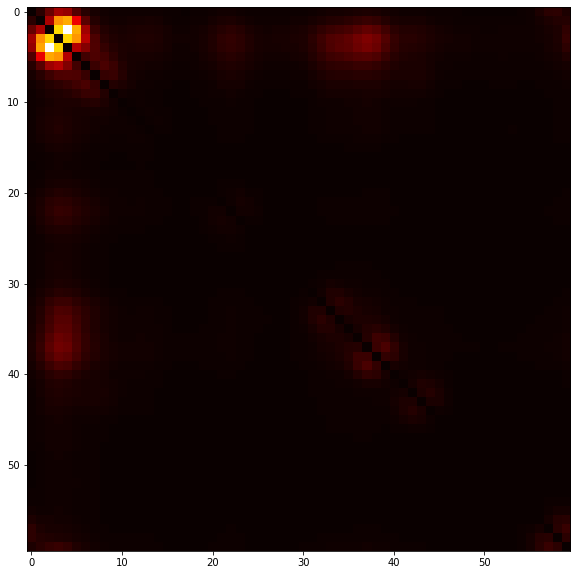

In [293]:
plt.figure(figsize=(10,10))
plt.imshow(ndms_input_val[0,:,:,0], cmap='hot', interpolation='nearest')

plt.show()

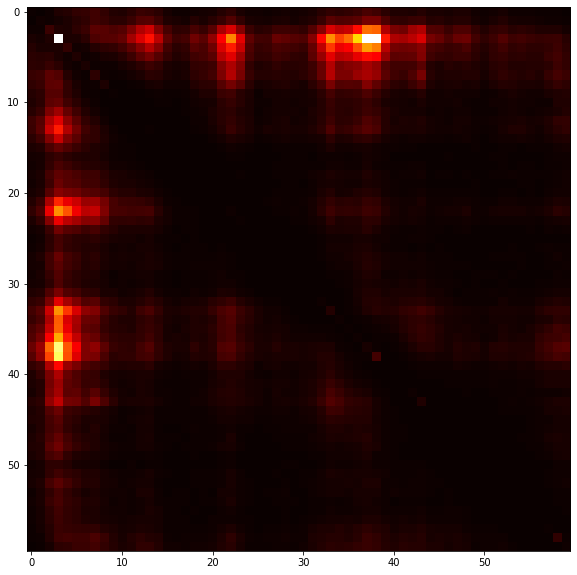

In [170]:
plt.figure(figsize=(10,10))
plt.imshow(ndms_input_val[0,:,:,0], cmap='hot', interpolation='nearest')

plt.show()

In [80]:
lm_file_ndms = h5py.File('images/ndms_cache_1.hdf5', "r")
X = []
y = []

for mbid,label in data[['mbid', 'labels']].values:
    a = lm_file_ndms[mbid][:,:,0]
#     a = a + a.T
    a = np.reshape(a, (-1))
#     a = lm_file_ndms[mbid][:,:,0]

    a = normalize_np(a)
#     a = np.power(a, 0.3)
    a = normalize_np(a)
    
#     b = lm_file_ndms[mbid][:,:,1]
# #     b = b + b.T
#     b = np.reshape(b, (-1))
# #     b = lm_file_ndms[mbid][:,:,1]
#     b = normalize_np(b)
# #     b = np.power(b, 0.7)
#     b = normalize_np(b)
    
#     a = b
    b=a
    
    X.append((a+b)/2)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [154]:
np.multiply(a,a)

array([0.47726938, 0.4135479 , 0.35056642, ..., 0.24285598, 0.43565676,
       0.5256641 ], dtype=float32)

In [60]:
import dictances

In [43]:
def normalize_np(z):
    z_min = np.min(z)
    return (z-z_min)/(np.max(z)-z_min)

In [45]:
def mean( hist ):
    mean = 0.0;
    for i in hist:
        mean += i;
    mean/= len(hist);
    return mean;

def bhatta( hist1,  hist2):
    # calculate mean of hist1
    h1_ = np.mean(hist1)
    h2_ = np.mean(hist2)
    # calculate mean of hist2

    
    # calculate score
    score = np.sum(np.sqrt(np.multiply(hist1, hist2)))
    # print h1_,h2_,score;
    score = math.sqrt( 1 - ( 1 / math.sqrt(h1_*h2_*len(hist1)*len(hist2)) ) * score );
    return score



In [185]:
bhatta(a,b)

0.08281073183392798

In [142]:
def KL(a, b):
    z = np.sum(np.where(a != 0, a * np.log(a / b), 0))
    print(z)
    return z
    

In [163]:
X_train.shape

(298, 3600)

[29] [29]
[19] [19]
[1] [1]
[11] [11]
[10] [10]
[13] [13]
[2] [2]
[10] [10]
[16] [16]
[5] [5]
[22] [22]
[9] [9]
[27] [17]
[26] [26]
[16] [28]
[24] [24]
[26] [26]
[18] [18]
[11] [11]
[27] [27]
[23] [23]
[11] [11]
[13] [13]
[3] [3]
[12] [12]
[9] [9]
[20] [20]
[8] [8]
[4] [4]
[20] [20]
[13] [13]
[15] [15]
[8] [8]
[22] [22]
[15] [15]
[4] [4]
[7] [7]
[22] [22]
[19] [19]
[25] [25]
[29] [26]
[17] [27]
[20] [20]
[21] [21]
[2] [2]
[1] [1]
[21] [21]
[9] [9]
[14] [14]
[29] [26]
[27] [27]
[16] [16]
[22] [16]
[20] [20]
[8] [8]
[25] [25]
[5] [5]
[26] [26]
[23] [23]
[18] [18]
[23] [23]
[23] [23]
[29] [29]
[17] [17]
[22] [22]
[20] [20]
[1] [1]
[18] [18]
[28] [28]
[3] [3]
[10] [10]
[15] [15]
[17] [17]
[0] [0]
[17] [6]
[4] [4]
[4] [4]
[19] [19]
[14] [14]
[19] [19]
[4] [4]
[25] [25]
[3] [3]
[22] [22]
[5] [5]
[12] [12]
[29] [26]
[13] [13]
[7] [7]
[8] [8]
[6] [6]
[10] [10]
[24] [24]
[10] [10]
[7] [7]
[20] [20]
[26] [26]
[25] [25]
[19] [14]
[20] [20]
[9] [9]
[28] [28]
[11] [18]
[17] [17]
[19] [19]
[0] [0]
[

In [1]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [3]:
si = summary_iterator("E:/MusicTransformer-tensorflow2.0/logs/mt_decoder/20210321-103704/eval/temp/events.out.tfevents.1616303224.SI-VISHWAASN.3336.64.v2")

In [7]:
next(si)

wall_time: 1616303231.060244
summary {
  value {
    tag: "vector"
    tensor {
      dtype: DT_STRING
      tensor_shape {
        dim {
          size: 3
        }
      }
      string_val: "63"
      string_val: "2048"
      string_val: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\000?\000\000\010\000\010\000\000\000\000\264\367\264\034\000\000 \000IDATx\234\215\375\355\222$9\216-\010\236C5\367\210\310\352\256{gFd\036d\337\377\205VVf\346\366tUf\204\273)\261?\360M\322<R%3\334L\215\037 \010\002 \010\200\270\200\377\355\037|\000\027\360?\371F\\ \000p\\c\340?\000r\\\027\310\307\377\347\237\027\336\376\300\037\2708\370\000\200\213\3771\000\010\354y\240<\002H\376\004\310M\301\372p\0100E\273\304\203\200}\314\232D\276\204L\260\3754\000D\273\003\365\327lE\377}\023\000s\371\275\325\'\332C\033\204=o\002\210\254\365\227:\275z{F4\271\274\334\321\022M\3246\246u\271\327o(z\371\334Y*\261\224\375\347P\275%\332\307\003|1\037\003\200x\001Y\177\216\356\000\260\r\306?\237\306/k1}q\241\317G\324?\203\010A